https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH = "../content/drive/My Drive/Нейронные сети 1_Модуль_2020/"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from math import radians, cos, sin, asin, sqrt # для вычисления расстояния до центра

import tensorflow
import keras


import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD 
from keras.utils import np_utils
from sklearn.preprocessing import StandardScaler
from keras.layers import SimpleRNN, LSTM


import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import nltk
nltk.download('punkt')
from nltk import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Введем callback
callbacks_list = [
        keras.callbacks.EarlyStopping(monitor='val_mae', patience=5),
        keras.callbacks.ReduceLROnPlateau(monitor='val_mae', factor=0.1, patience=10)  
]

In [ ]:
# Информация по фичам (название, кол-во пропущенных значений, число унивкальных значений, питонячий тип)
def get_info(df):
  return pd.DataFrame({'Feature': df.columns.tolist(),
              'NaN_count': df.isna().sum().tolist(),
              'number_of_unique_elements': pd.Series(df.columns.tolist()).apply(lambda row: df[row].nunique()),
              'type': pd.Series(df.columns.tolist()).apply(lambda row: df[row].dtype)
              })

# Загрузка и чистка данных 

In [ ]:
df = pd.read_csv(PATH+'AB_NYC_2019.csv',  sep=',', comment='#', error_bad_lines=False)
df.head()

b'Skipping line 24236: expected 16 fields, saw 17\nSkipping line 28204: expected 16 fields, saw 17\nSkipping line 30298: expected 16 fields, saw 17\n'


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365;;;;;
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149.0,1.0,9,2018-10-19,0.21,6,365;;;;;
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225.0,1.0,45,2019-05-21,0.38,2,355;;;;;
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Private room,150.0,3.0,0,NaN,NaN,1,365;;;;;
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89.0,1.0,270,2019-07-05,4.64,1,194;;;;;
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80.0,10.0,9,2018-11-19,0.10,1,0;;;;;


In [ ]:
df.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365;;;;;
49067,36484665,Charming one bedroom - newly renovated rowhouse,8232441,Sabrina,Brooklyn,Bedford-Stuyvesant,40.67853,-73.94995,Private room,70.0,2.0,0,NaN,NaN,2,9;;;;;
49068,36485057,Affordable room in Bushwick/East Williamsburg,6570630,Marisol,Brooklyn,Bushwick,40.70184,-73.93317,Private room,40.0,4.0,0,NaN,NaN,2,36;;;;;
49069,36485431,Sunny Studio at Historical Neighborhood,23492952,Ilgar & Aysel,Manhattan,Harlem,40.81475,-73.94867,Entire home/apt,115.0,10.0,0,NaN,NaN,1,27;;;;;
49070,36485609,43rd St. Time Square-cozy single bed,30985759,Taz,Manhattan,Hell's Kitchen,40.75751,-73.99112,Shared room,55.0,1.0,0,NaN,NaN,6,2;;;;;
49071,36487245,Trendy duplex in the very heart of Hell's Kitchen,68119814,Christophe,Manhattan,Hell's Kitchen,40.76404,-73.98933,Private room,90.0,7.0,0,NaN,NaN,1,23;;;;;


In [ ]:
df.columns[df.dtypes == 'object'].to_list()

['id',
 'name',
 'host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'longitude',
 'room_type',
 'number_of_reviews',
 'last_review',
 'calculated_host_listings_count',
 'availability_365;;;;;']

In [ ]:
# Удалим лишние ";"
df.columns = df.columns.str.replace(';', '') # из названий столбцов

for i in df.columns[df.dtypes == 'object'].to_list(): 
  if i == 'name': 
    df[i] = df[i].str.lower() 
  else:
    df[i] = df[i].str.replace(';', '')
    df[i] = df[i].str.replace('"', '') 
    df[i] = df[i].str.replace(' ', '') 

df['availability_365'] = df['availability_365'].astype('float')

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Privateroom,149.0,1.0,9,2018-10-19,0.21,6,365.0
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entirehome/apt,225.0,1.0,45,2019-05-21,0.38,2,355.0
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Privateroom,150.0,3.0,0,NaN,NaN,1,365.0
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,40.68514,-73.95976,Entirehome/apt,89.0,1.0,270,2019-07-05,4.64,1,194.0
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,40.79851,-73.94399,Entirehome/apt,80.0,10.0,9,2018-11-19,0.10,1,0.0


In [ ]:
df.shape

(49072, 16)

In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,49071,object
1,name,7558,40072,object
2,host_id,7973,32070,object
3,host_name,7990,10260,object
4,neighbourhood_group,7973,13,object
5,neighbourhood,7973,227,object
6,latitude,7973,17751,float64
7,longitude,7973,13662,object
8,room_type,7973,13,object
9,price,7973,635,float64


In [ ]:
df.describe()

,latitude,price,minimum_nights,reviews_per_month,availability_365
count,41099.000000,41099.000000,41099.000000,32541.000000,41089.000000
mean,40.701518,153.691160,6.901165,1.365592,112.660639
std,1.788728,242.943723,19.866836,1.677986,131.990560
min,-73.960070,0.000000,1.000000,0.010000,0.000000
25%,40.690605,70.000000,1.000000,0.190000,0.000000
50%,40.723520,109.000000,2.000000,0.710000,44.000000
75%,40.763320,179.000000,5.000000,2.010000,227.000000
max,40.913060,10000.000000,1250.000000,58.500000,365.000000


In [ ]:
df.describe(include='object')

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,longitude,room_type,number_of_reviews,last_review,calculated_host_listings_count
count,49072,41514,41099,41082,41099,41099,41099,41099,41099,32541,41099
unique,49071,40072,32070,10260,13,227,13662,13,395,1728,55
top,SoBro,home away from home,219517861,Michael,Manhattan,Williamsburg,-73.95405,Entirehome/apt,0,2019-06-23,1
freq,2,33,327,356,18549,3332,15,21368,8558,1183,27334


In [ ]:
# for i in ['host_id', 'number_of_reviews', 'calculated_host_listings_count']:
#   print(i)
#   df[i] = df[i].astype('float')

In [ ]:
# df[df['host_id'] == 'Jason']['id']

 есть строки, которые смещены

In [ ]:
# ошибочные строки исключаем
df = df[df['id'].str.contains(',')==False]
print(df.shape)
df.head()

(41559, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Privateroom,149.0,1.0,9,2018-10-19,0.21,6,365.0
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entirehome/apt,225.0,1.0,45,2019-05-21,0.38,2,355.0
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Privateroom,150.0,3.0,0,NaN,NaN,1,365.0
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,40.68514,-73.95976,Entirehome/apt,89.0,1.0,270,2019-07-05,4.64,1,194.0
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,40.79851,-73.94399,Entirehome/apt,80.0,10.0,9,2018-11-19,0.10,1,0.0


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41558,object
1,name,60,40058,object
2,host_id,475,32058,object
3,host_name,492,10258,object
4,neighbourhood_group,475,5,object
5,neighbourhood,475,217,object
6,latitude,475,17739,float64
7,longitude,475,13659,object
8,room_type,475,3,object
9,price,475,630,float64


Где пропущен Цена - Price удалим

In [ ]:
df = df[df['price'].isna()==False]
print(df.shape)
df.head()

(41084, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Privateroom,149.0,1.0,9,2018-10-19,0.21,6,365.0
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entirehome/apt,225.0,1.0,45,2019-05-21,0.38,2,355.0
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Privateroom,150.0,3.0,0,NaN,NaN,1,365.0
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,40.68514,-73.95976,Entirehome/apt,89.0,1.0,270,2019-07-05,4.64,1,194.0
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,40.79851,-73.94399,Entirehome/apt,80.0,10.0,9,2018-11-19,0.10,1,0.0


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41084,object
1,name,0,39761,object
2,host_id,0,32058,object
3,host_name,17,10258,object
4,neighbourhood_group,0,5,object
5,neighbourhood,0,217,object
6,latitude,0,17739,float64
7,longitude,0,13659,object
8,room_type,0,3,object
9,price,0,630,float64


Посмотрим на пропущенные оставшиеся значения

In [ ]:
df[df['host_name'].isna()].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
360,100184,bienvenue,526653,NaN,Queens,QueensVillage,40.72413,-73.76133,Privateroom,50.0,1.0,43,2019-07-08,0.45,1,88.0
2700,1449546,cozy studio in flatbush,7779204,NaN,Brooklyn,Flatbush,40.64965,-73.96154,Entirehome/apt,100.0,30.0,49,2017-01-02,0.69,1,342.0
5748,4183989,spring in the city!! zen-style tranquil bedroom,919218,NaN,Manhattan,Harlem,40.80606,-73.95061,Privateroom,86.0,3.0,34,2019-05-23,1.00,1,359.0
6078,4446862,charming room in prospect heights!,23077718,NaN,Brooklyn,CrownHeights,40.67512,-73.96146,Privateroom,50.0,1.0,0,NaN,NaN,1,0.0
8172,6292866,modern quiet gem near all,32722063,NaN,Brooklyn,EastFlatbush,40.65263,-73.93215,Entirehome/apt,85.0,2.0,182,2019-06-19,3.59,2,318.0


Заменим на частое

In [ ]:
df['host_name'] = df['host_name'].fillna(df['host_name'].describe()['top'])

In [ ]:
df[df['host_name'].isna()]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365


Признак review

In [ ]:
df[df['last_review'].isna()].head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Privateroom,150.0,3.0,0,NaN,NaN,1,365.0
19,7750,huge 2 br upper east cental park,17985,Sing,Manhattan,EastHarlem,40.79685,-73.94872,Entirehome/apt,190.0,7.0,0,NaN,NaN,2,249.0
26,8700,magnifique suite au n de manhattan - vue cloitres,26394,Claude&Sophie,Manhattan,Inwood,40.86754,-73.92639,Privateroom,80.0,4.0,0,NaN,NaN,1,0.0
36,11452,clean and quiet in brooklyn,7355,Vt,Brooklyn,Bedford-Stuyvesant,40.68876,-73.94312,Privateroom,35.0,60.0,0,NaN,NaN,1,365.0
38,11943,country space in the city,45445,Harriet,Brooklyn,Flatbush,40.63702,-73.96327,Privateroom,150.0,1.0,0,NaN,NaN,1,365.0


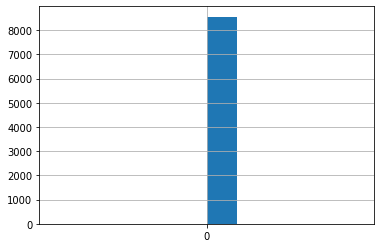

In [ ]:
df[df['last_review'].isna()]['number_of_reviews'].hist()

In [ ]:
df[df['last_review'].isna()]['number_of_reviews'].unique()

array(['0'], dtype=object)

In [ ]:
df[df['reviews_per_month'].isna()]['number_of_reviews'].unique()

array(['0'], dtype=object)

In [ ]:
# переведем в численный тип
df['number_of_reviews'] = df['number_of_reviews'].astype('int')

то есть Nan в признаках last_review, reviews_per_month означают, что квартиру еще не смотрели. 
Добавим признак "Not reviewed" - не просмотрено

In [ ]:
# превратим last_review в новый признак Кол-во дней с последнего просмотра

# Сначала заменим Nan на будущую дату
df['last_review'] = df['last_review'].fillna('2070-01-01')
# Переводим в формат даты
df['last_review'] = pd.to_datetime(df['last_review'])

# Новый признак "кол-во дней с последнего просмотра"
df['days_from_last_review'] = pd.to_datetime(datetime.now().strftime("%Y-%m-%d")) - df['last_review']
df['days_from_last_review'] = df['days_from_last_review'].astype('str')
df['days_from_last_review'] = df['days_from_last_review'].str.replace('days','')
df['days_from_last_review'] = df['days_from_last_review'].str.replace(' ','')
df['days_from_last_review'] = df['days_from_last_review'].astype('int')
df['days_from_last_review'].iloc[df['days_from_last_review']<0] = -1

# Nan в просмотрах в месяц заменим как 0
df['reviews_per_month'] = df['reviews_per_month'].fillna(0) 

# Новый признак "были ли вообще просмотры"
df['reviewed'] = 1
df['reviewed'].iloc[(df['number_of_reviews']==0)] = 0

# Новый признак какую часть года доступно жилье
df['availability_part_of_year'] = df['availability_365'] / 365 

df.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Privateroom,149.0,1.0,9,2018-10-19,0.21,6,365.0,736,1,1.000000
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entirehome/apt,225.0,1.0,45,2019-05-21,0.38,2,355.0,522,1,0.972603
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Privateroom,150.0,3.0,0,2070-01-01,0.00,1,365.0,-1,0,1.000000
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,40.68514,-73.95976,Entirehome/apt,89.0,1.0,270,2019-07-05,4.64,1,194.0,477,1,0.531507
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,40.79851,-73.94399,Entirehome/apt,80.0,10.0,9,2018-11-19,0.10,1,0.0,705,1,0.000000


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41084,object
1,name,0,39761,object
2,host_id,0,32058,object
3,host_name,0,10258,object
4,neighbourhood_group,0,5,object
5,neighbourhood,0,217,object
6,latitude,0,17739,float64
7,longitude,0,13659,object
8,room_type,0,3,object
9,price,0,630,float64


#### переведем фичи в правильный тип

##### выделим фичи по типу

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Privateroom,149.0,1.0,9,2018-10-19,0.21,6,365.0,736,1,1.000000
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entirehome/apt,225.0,1.0,45,2019-05-21,0.38,2,355.0,522,1,0.972603
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Privateroom,150.0,3.0,0,2070-01-01,0.00,1,365.0,-1,0,1.000000
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,40.68514,-73.95976,Entirehome/apt,89.0,1.0,270,2019-07-05,4.64,1,194.0,477,1,0.531507
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,40.79851,-73.94399,Entirehome/apt,80.0,10.0,9,2018-11-19,0.10,1,0.0,705,1,0.000000


In [ ]:
# Новые признаки от даты
df['year_last_reviewed'] = pd.DatetimeIndex(df['last_review']).year
df['month_last_reviewed'] = pd.DatetimeIndex(df['last_review']).month
df['day_last_reviewed'] = pd.DatetimeIndex(df['last_review']).day
df['weekday_last_reviewed'] = df['last_review'].dt.dayofweek

# Удалим дату last_review
df = df.drop(columns=['last_review'])

# выделим сезонность          
df['season'] = df['month_last_reviewed'].map({1: 'winter', 2: 'winter',
                                              3: 'spring', 4: 'spring', 5: 'spring',
                                              6: 'summer', 7: 'summer', 8: 'summer', 
                                              9: 'autumn', 10: 'autumn', 11: 'autumn',
                                              12: 'winter'})

In [ ]:
df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Privateroom,149.0,1.0,9,0.21,6,365.0,736,1,1.000000,2018,10,19,4,autumn
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entirehome/apt,225.0,1.0,45,0.38,2,355.0,522,1,0.972603,2019,5,21,1,spring
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.9419,Privateroom,150.0,3.0,0,0.00,1,365.0,-1,0,1.000000,2070,1,1,2,winter
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,40.68514,-73.95976,Entirehome/apt,89.0,1.0,270,4.64,1,194.0,477,1,0.531507,2019,7,5,4,summer
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,40.79851,-73.94399,Entirehome/apt,80.0,10.0,9,0.10,1,0.0,705,1,0.000000,2018,11,19,0,autumn


In [ ]:
get_info(df)#[get_info(df)['type']=='object']

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41084,object
1,name,0,39761,object
2,host_id,0,32058,object
3,host_name,0,10258,object
4,neighbourhood_group,0,5,object
5,neighbourhood,0,217,object
6,latitude,0,17739,float64
7,longitude,0,13659,object
8,room_type,0,3,object
9,price,0,630,float64


In [ ]:
# переведем в численный формат
df['calculated_host_listings_count'] = df['calculated_host_listings_count'].astype('int')
df['longitude'] = df['longitude'].astype('float')

In [ ]:
get_info(df)[get_info(df)['type']=='object']

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41084,object
1,name,0,39761,object
2,host_id,0,32058,object
3,host_name,0,10258,object
4,neighbourhood_group,0,5,object
5,neighbourhood,0,217,object
8,room_type,0,3,object
22,season,0,4,object


In [ ]:
# Новый признак - отдаленность в км от центра Нью Йорка 
def get_distance_to_center(lon1, lat1, lon2=-73.985550, lat2=40.757963):
    """
    lon2, lat2 - Координаты Таймс-сквер (40.757963, -73.985550)
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    # Radius of earth in kilometers is 6371
    km = 6371*c
    return km

df['distance_to_center'] = df.apply(lambda x: get_distance_to_center(x['longitude'], x['latitude']), axis=1)

# Удалим признаки с координатами
df = df.drop(columns=['longitude', 'latitude'])

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Privateroom,149.0,1.0,9,0.21,6,365.0,736,1,1.000000,2018,10,19,4,autumn,12.334179
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,Entirehome/apt,225.0,1.0,45,0.38,2,355.0,522,1,0.972603,2019,5,21,1,spring,0.505658
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,Privateroom,150.0,3.0,0,0.00,1,365.0,-1,0,1.000000,2070,1,1,2,winter,6.762982
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,Entirehome/apt,89.0,1.0,270,4.64,1,194.0,477,1,0.531507,2019,7,5,4,summer,8.384152
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,Entirehome/apt,80.0,10.0,9,0.10,1,0.0,705,1,0.000000,2018,11,19,0,autumn,5.707328


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41084,object
1,name,0,39761,object
2,host_id,0,32058,object
3,host_name,0,10258,object
4,neighbourhood_group,0,5,object
5,neighbourhood,0,217,object
6,room_type,0,3,object
7,price,0,630,float64
8,minimum_nights,0,98,float64
9,number_of_reviews,0,385,int64


In [ ]:
get_info(df)[get_info(df)['type']=='object']

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41084,object
1,name,0,39761,object
2,host_id,0,32058,object
3,host_name,0,10258,object
4,neighbourhood_group,0,5,object
5,neighbourhood,0,217,object
6,room_type,0,3,object
20,season,0,4,object


In [ ]:
# для категориальных фичей добавить частотность в качестве фичи

cat_cols = ['host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'season']

for i in cat_cols:
  new_col_name = str(i) + '_freq'
  df[new_col_name] = df[i].map(df.groupby(i).size())

df.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq
0,2539,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Privateroom,149.0,1.0,9,0.21,6,365.0,736,1,1.000000,2018,10,19,4,autumn,12.334179,5,255,16801,139,18720,3560
1,2595,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,Entirehome/apt,225.0,1.0,45,0.38,2,355.0,522,1,0.972603,2019,5,21,1,spring,0.505658,2,127,18549,1318,21366,6808
2,3647,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,Privateroom,150.0,3.0,0,0.00,1,365.0,-1,0,1.000000,2070,1,1,2,winter,6.762982,1,12,18549,2247,18720,13013
3,3831,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,Entirehome/apt,89.0,1.0,270,4.64,1,194.0,477,1,0.531507,2019,7,5,4,summer,8.384152,1,1,16801,487,21366,17703
4,5022,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,Entirehome/apt,80.0,10.0,9,0.10,1,0.0,705,1,0.000000,2018,11,19,0,autumn,5.707328,1,131,18549,962,21366,3560


In [ ]:
# Полезное вывод кол-ва записей по значениям в признаке
# df.groupby('room_type').size() или df['room_type'].value_counts()

In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,id,0,41084,object
1,name,0,39761,object
2,host_id,0,32058,object
3,host_name,0,10258,object
4,neighbourhood_group,0,5,object
5,neighbourhood,0,217,object
6,room_type,0,3,object
7,price,0,630,float64
8,minimum_nights,0,98,float64
9,number_of_reviews,0,385,int64


In [ ]:
df.columns

Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
       'neighbourhood', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'days_from_last_review', 'reviewed', 'availability_part_of_year',
       'year_last_reviewed', 'month_last_reviewed', 'day_last_reviewed',
       'weekday_last_reviewed', 'season', 'distance_to_center', 'host_id_freq',
       'host_name_freq', 'neighbourhood_group_freq', 'neighbourhood_freq',
       'room_type_freq', 'season_freq'],
      dtype='object')

In [ ]:
# удалим id из-за очень большого уникальных элементов
df = df.drop(columns=['id'])

print('Кол-во столбцов: ', df.shape[1])

# Выделим фичи по признаку
cat_cols = ['host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'season']
text_cols = ['name']

num_cols = set(df.columns) - set(cat_cols) - set(text_cols) - set(['price'])

print("Кол-во фичей: ", len(num_cols) + len(cat_cols) + len(text_cols))

Кол-во столбцов:  27
Кол-во фичей:  26


In [ ]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq
0,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Privateroom,149.0,1.0,9,0.21,6,365.0,736,1,1.000000,2018,10,19,4,autumn,12.334179,5,255,16801,139,18720,3560
1,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,Entirehome/apt,225.0,1.0,45,0.38,2,355.0,522,1,0.972603,2019,5,21,1,spring,0.505658,2,127,18549,1318,21366,6808
2,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,Privateroom,150.0,3.0,0,0.00,1,365.0,-1,0,1.000000,2070,1,1,2,winter,6.762982,1,12,18549,2247,18720,13013
3,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,Entirehome/apt,89.0,1.0,270,4.64,1,194.0,477,1,0.531507,2019,7,5,4,summer,8.384152,1,1,16801,487,21366,17703
4,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,Entirehome/apt,80.0,10.0,9,0.10,1,0.0,705,1,0.000000,2018,11,19,0,autumn,5.707328,1,131,18549,962,21366,3560


In [ ]:
get_info(df)

,Feature,NaN_count,number_of_unique_elements,type
0,name,0,39761,object
1,host_id,0,32058,object
2,host_name,0,10258,object
3,neighbourhood_group,0,5,object
4,neighbourhood,0,217,object
5,room_type,0,3,object
6,price,0,630,float64
7,minimum_nights,0,98,float64
8,number_of_reviews,0,385,int64
9,reviews_per_month,0,896,float64


In [ ]:
# закодировать как текст name - см на работе ноутбук
# категориальные фичи закодировать как на работе

In [ ]:
# # удалим id, name, host_ud из-за очень большого уникальных элементов
# df = df.drop(columns=['id', 'name', 'host_id'])

### EDA

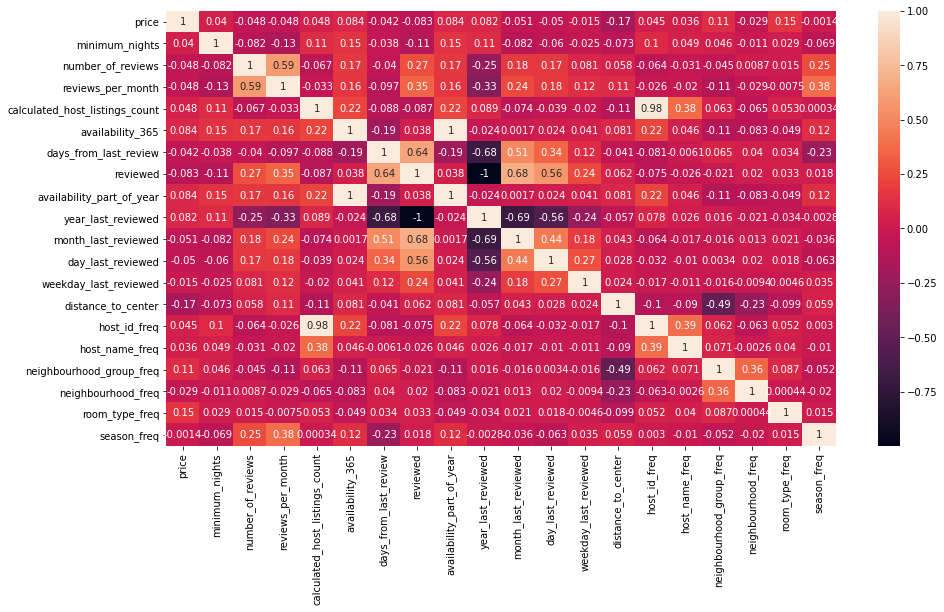

In [ ]:
# Корреляция признаков 
plt.figure(figsize=(15,8))
sns.heatmap(df.corr(), annot=True)

In [ ]:
df.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_from_last_review', 'reviewed',
       'availability_part_of_year', 'year_last_reviewed',
       'month_last_reviewed', 'day_last_reviewed', 'weekday_last_reviewed',
       'season', 'distance_to_center', 'host_id_freq', 'host_name_freq',
       'neighbourhood_group_freq', 'neighbourhood_freq', 'room_type_freq',
       'season_freq'],
      dtype='object')

Сильная корреляция у признаков: 
* host_id_freq и calculated_host_listings_count
* availability_part_of_year и availability_365
* year_last_reviewed и reviewed

In [ ]:
num_cols

{'availability_365',
 'availability_part_of_year',
 'calculated_host_listings_count',
 'day_last_reviewed',
 'days_from_last_review',
 'distance_to_center',
 'host_id_freq',
 'host_name_freq',
 'minimum_nights',
 'month_last_reviewed',
 'neighbourhood_freq',
 'neighbourhood_group_freq',
 'number_of_reviews',
 'reviewed',
 'reviews_per_month',
 'room_type_freq',
 'season_freq',
 'weekday_last_reviewed',
 'year_last_reviewed'}

#### Посмотрим числовые признаки

In [ ]:
df.describe(percentiles=[0.05,.25, .5, .75, 0.95])

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq
count,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000,41084.000000
mean,153.736369,6.895555,23.140371,1.080902,6.932236,112.646018,596.418168,0.791695,0.308619,2029.053792,5.096193,12.711859,2.971814,7.030407,6.424058,44.042401,15764.421186,1296.369974,19665.571999,13186.565135
std,242.975324,19.860432,44.672194,1.592732,32.764279,131.986213,479.687062,0.406101,0.361606,21.029823,3.084281,10.642531,2.064070,4.417840,31.169325,67.966801,4951.596688,1068.200396,3221.257692,4855.078860
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,2011.000000,1.000000,1.000000,0.000000,0.066682,1.000000,1.000000,289.000000,1.000000,998.000000,3560.000000
5%,40.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,2016.000000,1.000000,1.000000,0.000000,1.046723,1.000000,1.000000,4514.000000,52.000000,18720.000000,3560.000000
25%,70.000000,1.000000,1.000000,0.040000,1.000000,0.000000,478.000000,1.000000,0.000000,2018.000000,1.000000,1.000000,2.000000,3.764532,1.000000,3.000000,16801.000000,344.000000,18720.000000,6808.000000
50%,109.000000,2.000000,5.000000,0.360000,1.000000,44.000000,499.000000,1.000000,0.120548,2019.000000,6.000000,11.000000,2.000000,6.295499,1.000000,15.000000,16801.000000,962.000000,21366.000000,13013.000000
75%,179.000000,5.000000,23.000000,1.570000,2.000000,227.000000,724.000000,1.000000,0.621918,2019.000000,7.000000,23.000000,5.000000,9.352483,2.000000,58.000000,18549.000000,2048.000000,21366.000000,17703.000000
95%,360.000000,30.000000,114.000000,4.260000,15.000000,360.000000,1624.000000,1.000000,0.986301,2070.000000,11.000000,30.000000,6.000000,15.206883,13.000000,173.000000,18549.000000,3332.000000,21366.000000,17703.000000
max,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000,3470.000000,1.000000,1.000000,2070.000000,12.000000,31.000000,6.000000,35.892436,327.000000,373.000000,18549.000000,3332.000000,21366.000000,17703.000000


Есть выбросы: price, minimum_nights, number_of_reviews, reviews_per_month, calculated_host_listings_count, days_from_last_review

In [ ]:
df.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'room_type', 'price', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365', 'days_from_last_review', 'reviewed',
       'availability_part_of_year', 'year_last_reviewed',
       'month_last_reviewed', 'day_last_reviewed', 'weekday_last_reviewed',
       'season', 'distance_to_center', 'host_id_freq', 'host_name_freq',
       'neighbourhood_group_freq', 'neighbourhood_freq', 'room_type_freq',
       'season_freq'],
      dtype='object')

In [ ]:
list_ext = ['minimum_nights', 'number_of_reviews','reviews_per_month', 'calculated_host_listings_count', 'days_from_last_review']

In [ ]:
# Какая часть данных имеет выброс по каждому признаку
for k, v in df[list_ext].items():
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    irq = q3 - q1
    v_col = v[(v <= q1 - 1.5 * irq) | (v >= q3 + 1.5 * irq)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(df)[0]
    print("Column %s outliers = %.2f%%" % (k, perc))

Column minimum_nights outliers = 13.30%
Column number_of_reviews outliers = 12.89%
Column reviews_per_month outliers = 6.73%
Column calculated_host_listings_count outliers = 14.11%
Column days_from_last_review outliers = 35.02%


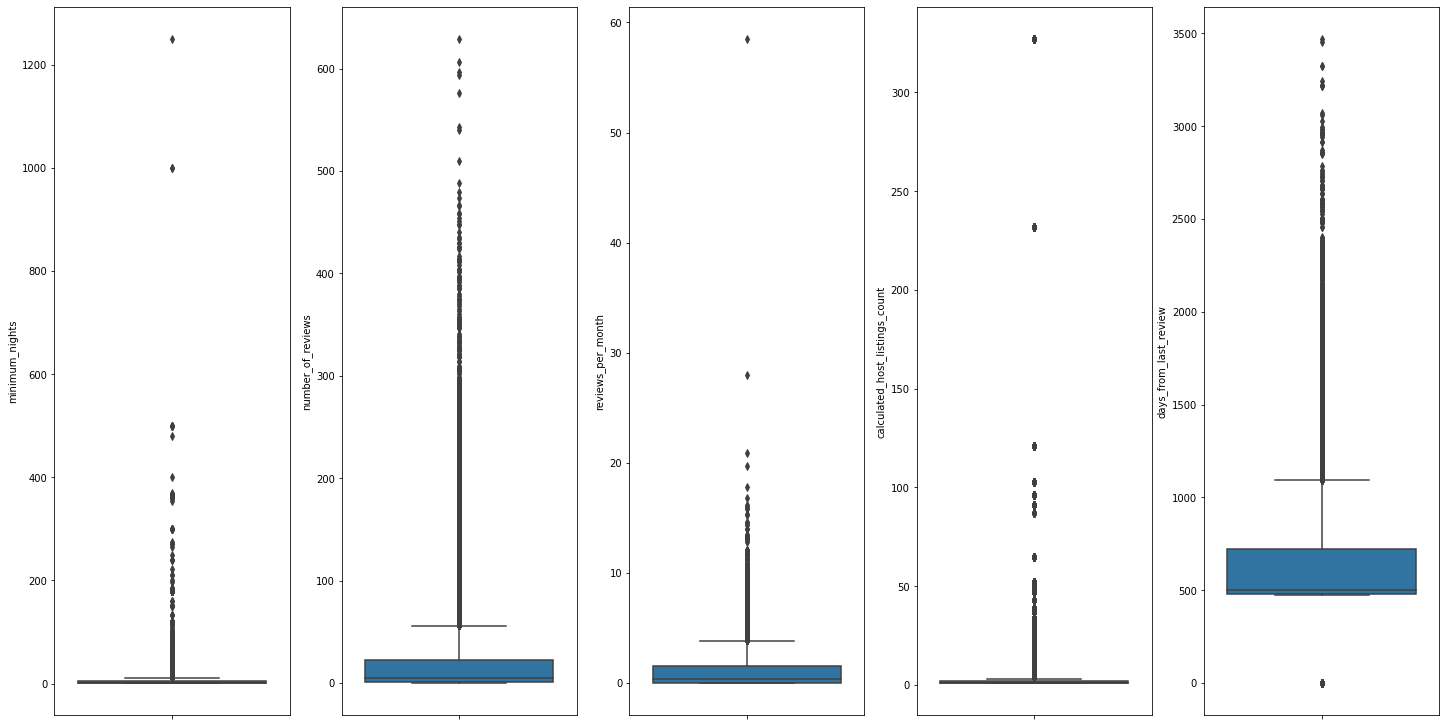

In [ ]:
fig, axs = plt.subplots(ncols=len(list_ext), figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df[list_ext].items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [ ]:
# Работаем с выбросами 
for col in list_ext:
    if col=='price':
        pass
    else:
        perc_90 = round(np.percentile(df[col], 90), 0)
        perc_10 = round(np.percentile(df[col], 10), 0)
        df.loc[df[col]>=perc_90, col] = perc_90
        df.loc[df[col]<=perc_10, col] = perc_10
        print(f'{col} заменяем выбросы снизу {perc_10}, сверху {perc_90}')

minimum_nights заменяем выбросы снизу 1.0, сверху 28.0
number_of_reviews заменяем выбросы снизу 0.0, сверху 70.0
reviews_per_month заменяем выбросы снизу 0.0, сверху 3.0
calculated_host_listings_count заменяем выбросы снизу 1.0, сверху 5.0
days_from_last_review заменяем выбросы снизу -1.0, сверху 1326.0


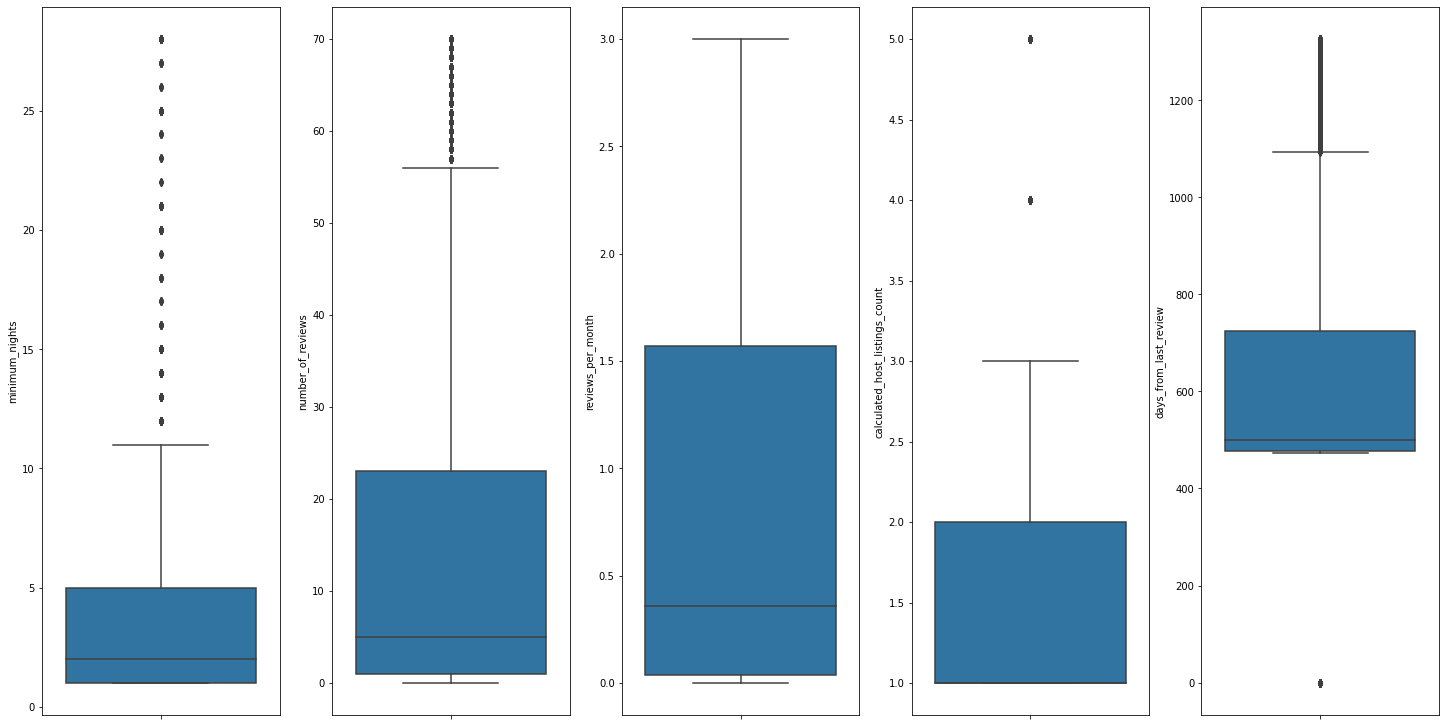

In [ ]:
fig, axs = plt.subplots(ncols=len(list_ext), figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df[list_ext].items():
    sns.boxplot(y=k, data=df, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

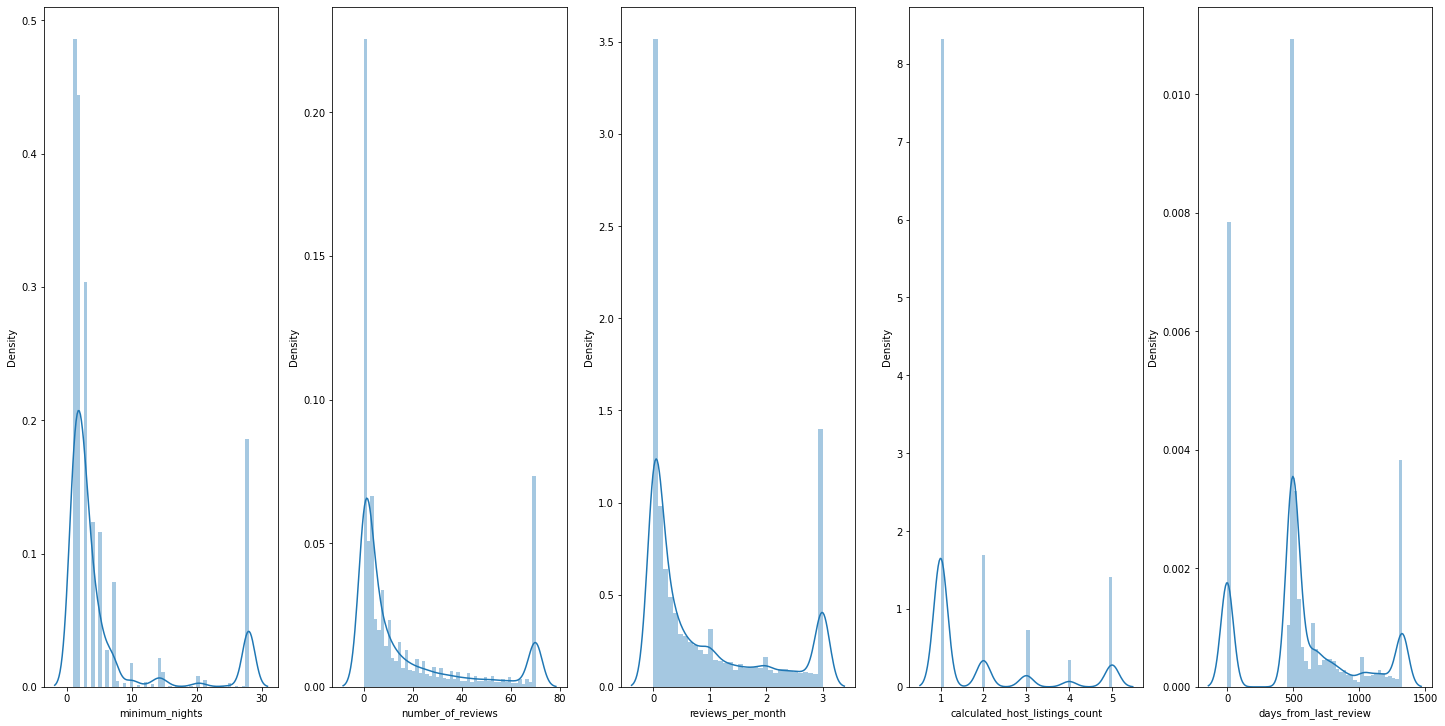

In [ ]:
fig, axs = plt.subplots(ncols=len(list_ext), figsize=(20, 10))
index = 0
axs = axs.flatten()
for k,v in df[list_ext].items():
    sns.distplot(v, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

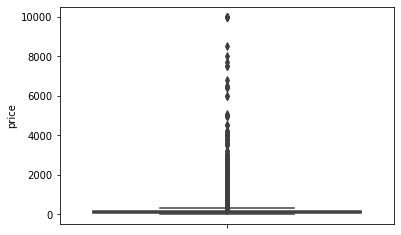

In [ ]:
sns.boxplot(y='price', data=df)

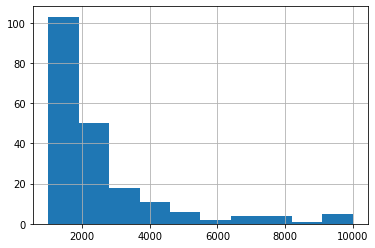

In [ ]:
df[df['price']>1000]['price'].hist()

In [ ]:
# Удалим слишком дорогие квартиры
df = df[df['price']<=1000]

In [ ]:
# Посмотрим еще раз на числовые признаки 
df.describe()

,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq
count,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000,40880.000000
mean,142.027666,5.669594,16.879232,0.903921,1.787427,112.289114,561.290435,0.793444,0.307641,2028.964359,5.105626,12.738234,2.974242,7.041028,6.437842,44.029012,15756.733513,1297.587867,19660.477838,13189.339359
std,117.342098,8.043277,23.151395,1.067330,1.343686,131.766264,394.335778,0.404839,0.361003,20.964105,3.080132,10.640681,2.066058,4.414531,31.235881,67.993050,4956.682032,1068.935443,3224.705894,4860.915610
min,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,2011.000000,1.000000,1.000000,0.000000,0.066682,1.000000,1.000000,289.000000,1.000000,998.000000,3560.000000
25%,69.000000,1.000000,1.000000,0.040000,1.000000,0.000000,478.000000,1.000000,0.000000,2018.000000,1.000000,1.000000,2.000000,3.775391,1.000000,3.000000,16801.000000,344.000000,18720.000000,6808.000000
50%,108.000000,2.000000,5.000000,0.370000,1.000000,43.000000,499.000000,1.000000,0.117808,2019.000000,6.000000,11.000000,2.000000,6.313147,1.000000,15.000000,16801.000000,962.000000,21366.000000,13013.000000
75%,175.000000,5.000000,23.000000,1.580000,2.000000,226.000000,724.000000,1.000000,0.619178,2019.000000,7.000000,23.000000,5.000000,9.361360,2.000000,58.000000,18549.000000,2048.000000,21366.000000,17703.000000
max,1000.000000,28.000000,70.000000,3.000000,5.000000,365.000000,1326.000000,1.000000,1.000000,2070.000000,12.000000,31.000000,6.000000,35.892436,327.000000,373.000000,18549.000000,3332.000000,21366.000000,17703.000000


выбросов стало меньше 


In [ ]:
 df.shape

(40880, 27)

In [ ]:
# Сохраним обработнные данные 
# df = df.reset_index(drop=True)
# df.to_csv(PATH+'df_prepared.csv')

In [ ]:
# Загрузим обработанные данные
df = pd.read_csv(PATH+'df_prepared.csv', index_col=[0])
df = df.reset_index(drop=True)
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq
0,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Privateroom,149.0,1.0,9.0,0.21,5.0,365.0,736.0,1,1.000000,2018,10,19,4,autumn,12.334179,5,255,16801,139,18720,3560
1,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,Entirehome/apt,225.0,1.0,45.0,0.38,2.0,355.0,522.0,1,0.972603,2019,5,21,1,spring,0.505658,2,127,18549,1318,21366,6808
2,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,Privateroom,150.0,3.0,0.0,0.00,1.0,365.0,-1.0,0,1.000000,2070,1,1,2,winter,6.762982,1,12,18549,2247,18720,13013
3,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,Entirehome/apt,89.0,1.0,70.0,3.00,1.0,194.0,477.0,1,0.531507,2019,7,5,4,summer,8.384152,1,1,16801,487,21366,17703
4,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,Entirehome/apt,80.0,10.0,9.0,0.10,1.0,0.0,705.0,1,0.000000,2018,11,19,0,autumn,5.707328,1,131,18549,962,21366,3560


# Подготовка данных для моделей

In [ ]:
# Выделим фичи по признаку
cat_cols = ['host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'room_type', 'season']
text_cols = ['name']

num_cols = set(df.columns) - set(cat_cols) - set(text_cols) - set(['price'])
print("Кол-во столбцов:", df.shape[1])
print("Кол-во фичей: ", len(num_cols) + len(cat_cols) + len(text_cols))

Кол-во столбцов: 27
Кол-во фичей:  26


### Обработка текстовых признаков

In [ ]:
text_cols

['name']

In [ ]:
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq
0,clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,Privateroom,149.0,1.0,9.0,0.21,5.0,365.0,736.0,1,1.000000,2018,10,19,4,autumn,12.334179,5,255,16801,139,18720,3560
1,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,Entirehome/apt,225.0,1.0,45.0,0.38,2.0,355.0,522.0,1,0.972603,2019,5,21,1,spring,0.505658,2,127,18549,1318,21366,6808
2,the village of harlem....new york !,4632,Elisabeth,Manhattan,Harlem,Privateroom,150.0,3.0,0.0,0.00,1.0,365.0,-1.0,0,1.000000,2070,1,1,2,winter,6.762982,1,12,18549,2247,18720,13013
3,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,Entirehome/apt,89.0,1.0,70.0,3.00,1.0,194.0,477.0,1,0.531507,2019,7,5,4,summer,8.384152,1,1,16801,487,21366,17703
4,entire apt: spacious studio/loft by central park,7192,Laura,Manhattan,EastHarlem,Entirehome/apt,80.0,10.0,9.0,0.10,1.0,0.0,705.0,1,0.000000,2018,11,19,0,autumn,5.707328,1,131,18549,962,21366,3560


In [ ]:
# Почистим столбец Name - оставим только слова
def text_process(text):
       
    tokenized_text = word_tokenize(text, 'english')
    
    # Удаление пунктуации и прочих символов
    no_punctuation = [token for token in tokenized_text if token.isalpha()]
    
    return ' '.join(no_punctuation).lower()

df['name'] = df['name'].apply(text_process)
df.head()

,name,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq
0,clean quiet apt home by the park,2787,John,Brooklyn,Kensington,Privateroom,149.0,1.0,9.0,0.21,5.0,365.0,736.0,1,1.000000,2018,10,19,4,autumn,12.334179,5,255,16801,139,18720,3560
1,skylit midtown castle,2845,Jennifer,Manhattan,Midtown,Entirehome/apt,225.0,1.0,45.0,0.38,2.0,355.0,522.0,1,0.972603,2019,5,21,1,spring,0.505658,2,127,18549,1318,21366,6808
2,the village of harlem york,4632,Elisabeth,Manhattan,Harlem,Privateroom,150.0,3.0,0.0,0.00,1.0,365.0,-1.0,0,1.000000,2070,1,1,2,winter,6.762982,1,12,18549,2247,18720,13013
3,cozy entire floor of brownstone,4869,LisaRoxanne,Brooklyn,ClintonHill,Entirehome/apt,89.0,1.0,70.0,3.00,1.0,194.0,477.0,1,0.531507,2019,7,5,4,summer,8.384152,1,1,16801,487,21366,17703
4,entire apt spacious by central park,7192,Laura,Manhattan,EastHarlem,Entirehome/apt,80.0,10.0,9.0,0.10,1.0,0.0,705.0,1,0.000000,2018,11,19,0,autumn,5.707328,1,131,18549,962,21366,3560


In [ ]:
tf_idf = TfidfVectorizer()

text_tf_idf = tf_idf.fit_transform(df['name'].values.tolist())
text_tf_idf


<40880x5516 sparse matrix of type '<class 'numpy.float64'>'
	with 211383 stored elements in Compressed Sparse Row format>

In [ ]:
tsvd = TruncatedSVD(n_components=3)
text_tf_idf_tsvd = tsvd.fit_transform(text_tf_idf)
text_tf_idf_tsvd.shape

(40880, 3)

In [ ]:
df_tsvd = pd.DataFrame(text_tf_idf_tsvd)
df_tsvd.columns = ['name_'+'component_svd_'+str(i) for i in df_tsvd.columns]
df_tsvd.head()

,name_component_svd_0,name_component_svd_1,name_component_svd_2
0,0.160857,-0.076568,0.064362
1,0.015958,-0.012309,-0.002474
2,0.181513,-0.246050,0.352328
3,0.158690,-0.081074,0.121412
4,0.165674,-0.050604,-0.130421


In [ ]:
# Добавляем столбцы 
df = pd.concat([df, df_tsvd], axis=1)

# Удалим столбец Name 
df = df.drop(columns=['name'])
df.head()

,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq,name_component_svd_0,name_component_svd_1,name_component_svd_2
0,2787,John,Brooklyn,Kensington,Privateroom,149.0,1.0,9.0,0.21,5.0,365.0,736.0,1,1.000000,2018,10,19,4,autumn,12.334179,5,255,16801,139,18720,3560,0.160857,-0.076568,0.064362
1,2845,Jennifer,Manhattan,Midtown,Entirehome/apt,225.0,1.0,45.0,0.38,2.0,355.0,522.0,1,0.972603,2019,5,21,1,spring,0.505658,2,127,18549,1318,21366,6808,0.015958,-0.012309,-0.002474
2,4632,Elisabeth,Manhattan,Harlem,Privateroom,150.0,3.0,0.0,0.00,1.0,365.0,-1.0,0,1.000000,2070,1,1,2,winter,6.762982,1,12,18549,2247,18720,13013,0.181513,-0.246050,0.352328
3,4869,LisaRoxanne,Brooklyn,ClintonHill,Entirehome/apt,89.0,1.0,70.0,3.00,1.0,194.0,477.0,1,0.531507,2019,7,5,4,summer,8.384152,1,1,16801,487,21366,17703,0.158690,-0.081074,0.121412
4,7192,Laura,Manhattan,EastHarlem,Entirehome/apt,80.0,10.0,9.0,0.10,1.0,0.0,705.0,1,0.000000,2018,11,19,0,autumn,5.707328,1,131,18549,962,21366,3560,0.165674,-0.050604,-0.130421


### обработка категориальных признаков

In [ ]:
cat_cols

['host_id',
 'host_name',
 'neighbourhood_group',
 'neighbourhood',
 'room_type',
 'season']

In [ ]:
for item in cat_cols: 
  df[item] = df[item].astype("category").cat.codes + 1 
  
df.head()

,host_id,host_name,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,days_from_last_review,reviewed,availability_part_of_year,year_last_reviewed,month_last_reviewed,day_last_reviewed,weekday_last_reviewed,season,distance_to_center,host_id_freq,host_name_freq,neighbourhood_group_freq,neighbourhood_freq,room_type_freq,season_freq,name_component_svd_0,name_component_svd_1,name_component_svd_2
0,3,4437,2,107,2,149.0,1.0,9.0,0.21,5.0,365.0,736.0,1,1.000000,2018,10,19,4,1,12.334179,5,255,16801,139,18720,3560,0.160857,-0.076568,0.064362
1,4,4256,3,126,1,225.0,1.0,45.0,0.38,2.0,355.0,522.0,1,0.972603,2019,5,21,1,2,0.505658,2,127,18549,1318,21366,6808,0.015958,-0.012309,-0.002474
2,13,2573,3,93,2,150.0,3.0,0.0,0.00,1.0,365.0,-1.0,0,1.000000,2070,1,1,2,4,6.762982,1,12,18549,2247,18720,13013,0.181513,-0.246050,0.352328
3,14,5539,2,41,1,89.0,1.0,70.0,3.00,1.0,194.0,477.0,1,0.531507,2019,7,5,4,3,8.384152,1,1,16801,487,21366,17703,0.158690,-0.081074,0.121412
4,18,5285,3,61,1,80.0,10.0,9.0,0.10,1.0,0.0,705.0,1,0.000000,2018,11,19,0,1,5.707328,1,131,18549,962,21366,3560,0.165674,-0.050604,-0.130421


### обработка числовых признаков

In [ ]:
def get_standarted_data(df, num_cols, type_data='train', scaler=None, except_features=None):
  '''
  Выдает датасэт с стандартизированными признакам.
  except_features - список фичей, которые не надо категоризовать 
  scaler - ф-ция стандартизации 
  '''

  # обновим индексы 
  df = df.reset_index(drop=True)

  # Исключим некоторые числовые признаки 
  if except_features: 
    for j in except_features:
      print(j)
      num_cols.remove(j)

  # ф-ция стандартизации 
  if  type_data == 'train': 
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df[num_cols]), columns=num_cols)
  elif type_data == 'test':
    df_scaled = pd.DataFrame(scaler.transform(df[num_cols]), columns=num_cols)

  # Удаляем исходные числовые признаки
  df = df.drop(columns=num_cols)

  # Присоединяем уже в стандризированном виде 
  df = pd.concat([df_scaled, df], axis=1)
  del df_scaled 
  
  return df, scaler 

In [ ]:
# Поделим на фичи и таргет
X = df.drop(columns=['price']) 
y = df['price']

In [ ]:
get_info(X)

,Feature,NaN_count,number_of_unique_elements,type
0,host_id,0,31911,int16
1,host_name,0,10223,int16
2,neighbourhood_group,0,5,int8
3,neighbourhood,0,217,int16
4,room_type,0,3,int8
5,minimum_nights,0,28,float64
6,number_of_reviews,0,71,float64
7,reviews_per_month,0,301,float64
8,calculated_host_listings_count,0,5,float64
9,availability_365,0,366,float64


In [ ]:
# Стандартизация
X, _ = get_standarted_data(X, num_cols, 'train')
print(X.shape)

(40880, 28)


In [ ]:
df.shape

(40880, 29)

In [ ]:
# # Сохраним фичи и таргет
# X.to_csv(PATH+'X_prepared')
# y.to_csv(PATH+'y_prepared')

In [ ]:
# # Загрузим фичи и таргет
X = pd.read_csv(PATH+'X_prepared', index_col=[0])
y = pd.read_csv(PATH+'y_prepared', index_col=[0])

## Построение модели

In [ ]:
get_info(X)

,Feature,NaN_count,number_of_unique_elements,type
0,neighbourhood_group_freq,0,5,float64
1,minimum_nights,0,28,float64
2,season_freq,0,4,float64
3,year_last_reviewed,0,10,float64
4,calculated_host_listings_count,0,5,float64
5,neighbourhood_freq,0,118,float64
6,month_last_reviewed,0,12,float64
7,availability_365,0,366,float64
8,reviews_per_month,0,301,float64
9,number_of_reviews,0,71,float64


### Простые модели: Лог регрессия и Случайный Лес

In [ ]:
def train_linear_model(X, y, validation_split=0.2): 
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_split, random_state=42)
  
  print(X_train.shape)
  print(y_train.shape)
  
  # Регрессия
  lr = LinearRegression()
  lr.fit(X_train, y_train)

  mae_train = mean_absolute_error(y_train, lr.predict(X_train))
  mse_train = mean_squared_error(y_train, lr.predict(X_train))

  mae_test = mean_absolute_error(y_test, lr.predict(X_test))
  mse_test = mean_squared_error(y_test, lr.predict(X_test))

  # Результат по моделям в виде датафрэйма
  result_lr = pd.DataFrame({'model': 'Linear', 
                          'mae_train': mae_train, 'mae_test': mae_test
                          }, index=[0])


  # Случайный лес
  rf = RandomForestRegressor(random_state=17)
  rf.fit(X_train, y_train)

  mae_train_rf = mean_absolute_error(y_train, rf.predict(X_train))
  mse_train_rf = mean_squared_error(y_train, rf.predict(X_train))

  mae_test_rf = mean_absolute_error(y_test, rf.predict(X_test))
  mse_test_rf = mean_squared_error(y_test, rf.predict(X_test))

  # Результат по моделям в виде датафрэйма
  result_rf = pd.DataFrame({'model': 'Random Forest', 
                          'mae_train': mae_train_rf, 'mae_test': mae_test_rf
                          }, index=[0])

  for i in [lr, rf]:
    # Графики сравнения моделей
    _, ax = plt.subplots(figsize=(8, 6))

    y_pred = i.predict(X_test)

    ax.scatter(y=y_pred, x=y_test, c = 'red')
    plt.title('True/Predicted value of'+str(i)+' model')
    plt.ylabel('Predicted value')
    plt.xlabel('True value')
    plt.legend()
    plt.show()

  result = pd.concat([result_lr, result_rf])
  result = result.reset_index(drop=True)
  return result
 

(32704, 28)
(32704,)


No handles with labels found to put in legend.


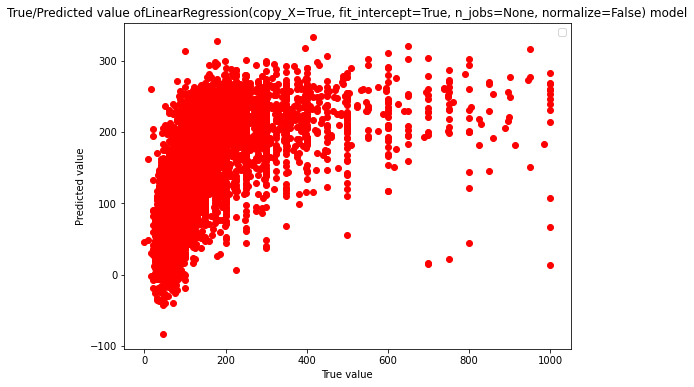

No handles with labels found to put in legend.


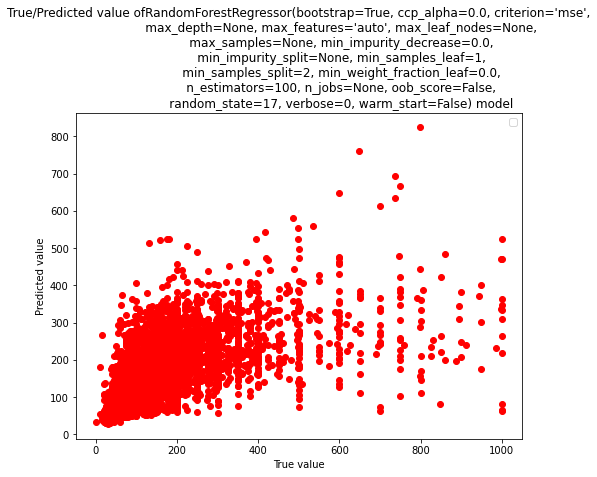

In [ ]:
result = train_linear_model(X,y)

In [ ]:
result

,model,mae_train,mae_test
0,Linear,56.592300,56.812386
1,Random Forest,18.738989,50.749094


### модели НС

In [ ]:
def train_model(X, y, callbacks_list, num_epochs=50, validation_split=0.2): 
  
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_split, random_state=42)
  
  print(X_train.shape)
  print(y_train.shape)

  # # Стандартизация 
  # scaler = StandardScaler()
  # X_train = scaler.fit_transform(X_train)
  # X_test = scaler.transform(X_test)

  #### Сети #### 
  
  # 1 слой
  model1 = Sequential()
  model1.add(Dense(10000, activation='relu', input_shape=(X.shape[1],)))
  model1.add(Dense(1, activation='linear'))
  model1.compile(optimizer='adam', loss='mse', metrics=['mae'])

  h1 = model1.fit(X_train, y_train, epochs=num_epochs,
                  verbose=0, validation_split=validation_split,
                  callbacks=callbacks_list)
  
  mse_train, mae_train = model1.evaluate(X_train, y_train, verbose=0)
  mse_test, mae_test = model1.evaluate(X_test, y_test, verbose=0)
  
  result1 = pd.DataFrame({ 'dense_cnt': 1, 'mae_train': mae_train,
                           'mae_test': mae_test
                          }, index=[0])
  
  # 2 слоя 
  model2 = Sequential()
  model2.add(Dense(10000, activation='relu', input_shape=(X.shape[1],)))
  model2.add(Dense(5000, activation='relu'))
  model2.add(Dense(1, activation='linear'))
  model2.compile(optimizer='adam', loss='mse', metrics=['mae'])

  h2 = model2.fit(X_train, y_train, epochs=num_epochs, 
                  verbose=0, validation_split=validation_split,
                  callbacks=callbacks_list)

  mse_train, mae_train = model2.evaluate(X_train, y_train, verbose=0)
  mse_test, mae_test = model2.evaluate(X_test, y_test, verbose=0)
  
  result2 = pd.DataFrame({'dense_cnt': 2, 
                          'mae_train': mae_train, 'mae_test': mae_test
                          }, index=[0])

  # 3 слоя
  model3 = Sequential()
  model3.add(Dense(10000, activation='relu', input_shape=(X.shape[1],)))
  model3.add(Dense(5000, activation='relu'))
  model3.add(Dense(500, activation='relu'))
  model3.add(Dense(1, activation='linear')) 
  model3.compile(optimizer='adam', loss='mse', metrics=['mae'])

  h3 = model3.fit(X_train, y_train, epochs=num_epochs,
                  verbose=0, validation_split=validation_split,
                  callbacks=callbacks_list)

  mse_train, mae_train = model3.evaluate(X_train, y_train, verbose=0)
  mse_test, mae_test = model3.evaluate(X_test, y_test, verbose=0)
  
  # Результат по моделям в виде датафрэйма
  result3 = pd.DataFrame({'dense_cnt': 3, 
                          'mae_train': mae_train, 'mae_test': mae_test
                          }, index=[0])

  # Графики работы моделей
  for h in [h1, h2, h3]:
      plt.subplots(figsize=(8, 6)) 
      # Mae values
      plt.plot(h.history['mae'])
      plt.plot(h.history['val_mae']) # для тренировочного 
      plt.title('Model'+str(h)+'mae')
      plt.ylabel('mae')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()

      plt.subplots(figsize=(8, 6)) 
      # Loss values
      plt.plot(h.history['loss'])
      plt.plot(h.history['val_loss']) # для тренировочного 
      plt.title('Model'+str(h)+'Loss')
      plt.ylabel('loss')
      plt.xlabel('Epoch')
      plt.legend(['Train', 'Test'], loc='upper left')
      plt.show()
    

  # Графики сравнения моделей
  for i in enumerate([model1, model2, model3]):
    _, ax = plt.subplots(figsize=(8, 6))

    y_pred = i[1].predict(X_test)

    ax.scatter(y=y_pred, x=y_test, c = 'red')
    plt.title('True/Predicted value of model №'+str(i[0]+1))
    plt.ylabel('Predicted value')
    plt.xlabel('True value')
    plt.legend()
    plt.show()


  result = pd.concat([result1, result2, result3])
  result = result.reset_index(drop=True)
  return result
 

(32704, 28)
(32704, 1)


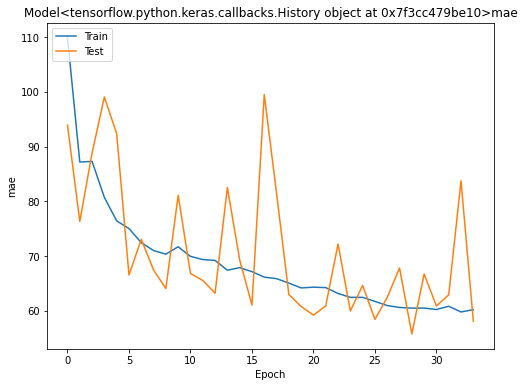

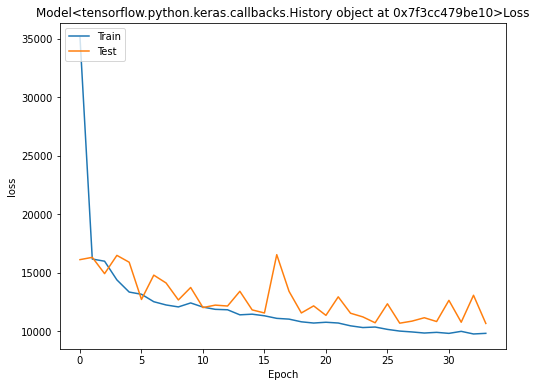

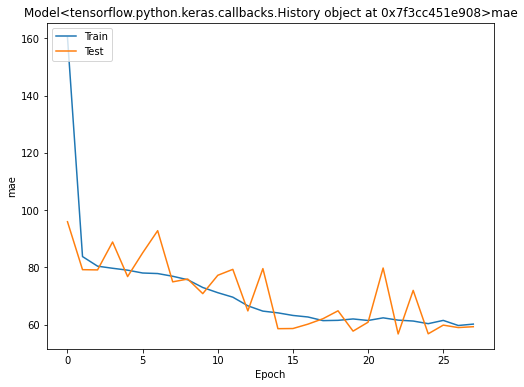

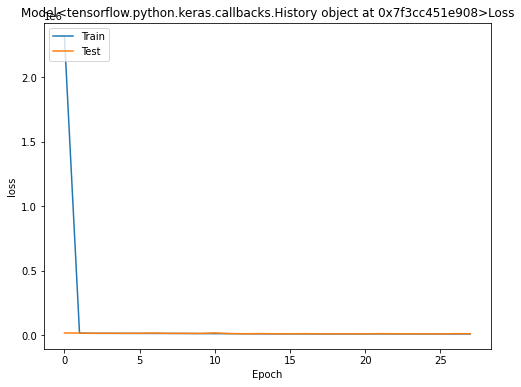

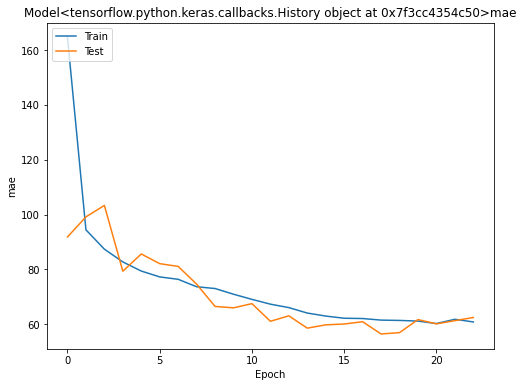

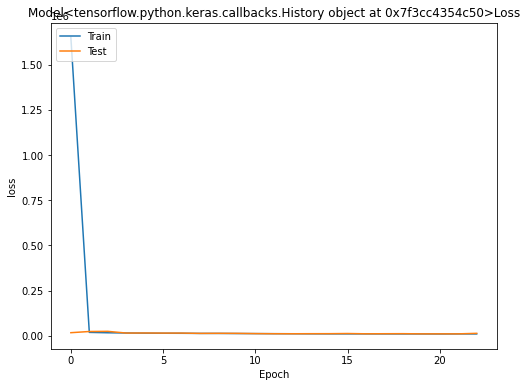

No handles with labels found to put in legend.


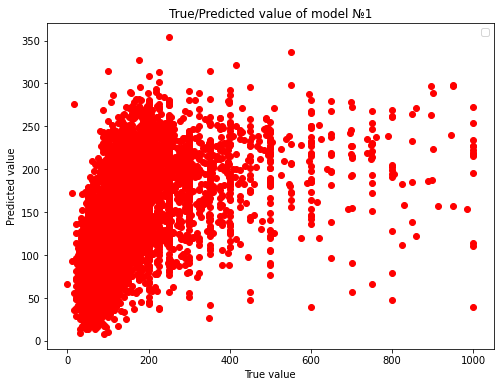

No handles with labels found to put in legend.


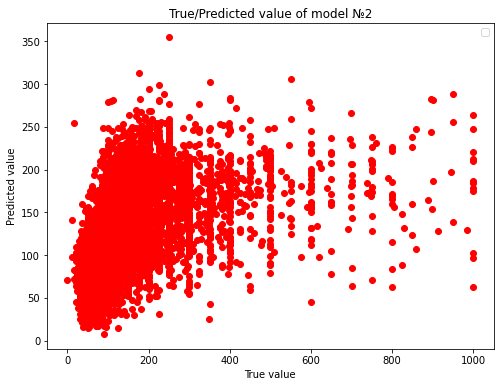

No handles with labels found to put in legend.


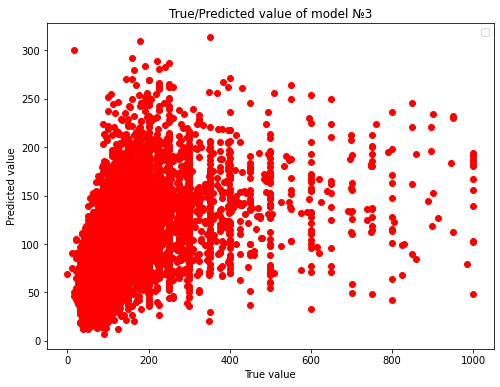

In [ ]:
%%time
result = train_model(X, y, callbacks_list, validation_split=0.2)

In [ ]:
result

,dense_cnt,mae_train,mae_test
0,1,56.774017,57.306099
1,2,57.753517,57.893711
2,3,60.883343,60.741173


Рез-ты получились плохие.

# Эксперименты для одной архитектуры сети